# Importing Libraries and Data

In [1]:
import numpy 
import pandas
import torch
import random
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import functional
from torchmetrics import Recall, Precision
from collections import defaultdict
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image


In [2]:
directory = '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset'

transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

data = ImageFolder(directory,transform = transformer)

In [3]:
class_names = data.classes
class_names

['Apple__Healthy',
 'Apple__Rotten',
 'Banana__Healthy',
 'Banana__Rotten',
 'Bellpepper__Healthy',
 'Bellpepper__Rotten',
 'Carrot__Healthy',
 'Carrot__Rotten',
 'Cucumber__Healthy',
 'Cucumber__Rotten',
 'Grape__Healthy',
 'Grape__Rotten',
 'Guava__Healthy',
 'Guava__Rotten',
 'Jujube__Healthy',
 'Jujube__Rotten',
 'Mango__Healthy',
 'Mango__Rotten',
 'Orange__Healthy',
 'Orange__Rotten',
 'Pomegranate__Healthy',
 'Pomegranate__Rotten',
 'Potato__Healthy',
 'Potato__Rotten',
 'Strawberry__Healthy',
 'Strawberry__Rotten',
 'Tomato__Healthy',
 'Tomato__Rotten']

In [4]:
print ("Dataset Length", len(data))

generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(data, [0.7, 0.2, 0.1], generator = generator1)


train_loader = DataLoader(train_dataset, batch_size =16 , shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

print ("Train Length", len(train_dataset))
print ("Validation Length", len(val_dataset))
print ("Test Length", len(test_dataset))

Dataset Length 29291
Train Length 20504
Validation Length 5858
Test Length 2929


# Previewing Images

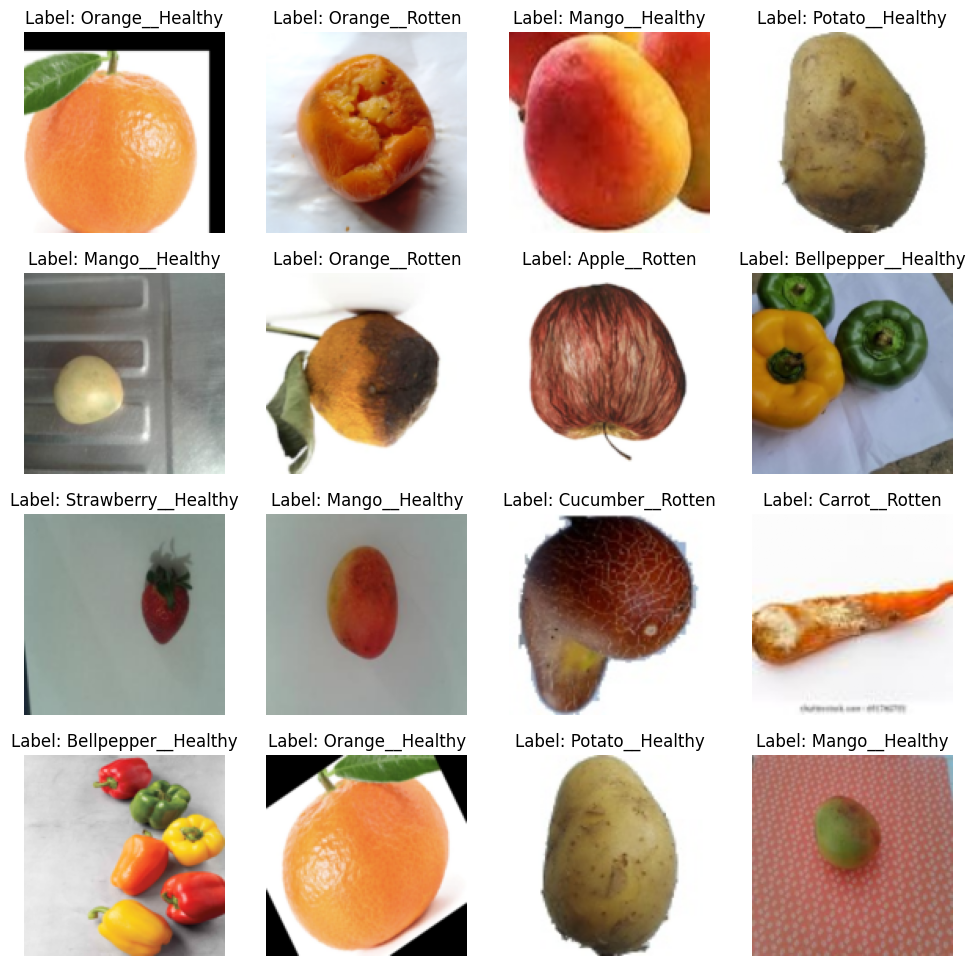

In [5]:
dataloader = DataLoader(data, batch_size = 16, shuffle = True)
images, labels = next(iter(dataloader))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = images[i].permute(1, 2, 0).numpy() 
        label = labels[i].item() 
        ax.imshow(img)
        ax.set_title(f'Label: {class_names[label]}')
        ax.axis('off')

In [6]:
#Check how many channels are present in the image
num_channels = functional.get_image_num_channels(images[0])
print ("Num Channels: ", num_channels)

Num Channels:  3


# Image Classification with ResNet50

In [7]:
model = models.resnet50(pretrained = True)

for name, param in model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.95)

device = torch.device ("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        model.train()
        outputs = model(inputs)
        loss = criterion (outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    
    model.eval()
    val_loss = 0.0
    val_correct = 0.0
    val_total = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion (outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * val_correct / val_total}')            

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/4], Loss: 1.2157720728848542
Validation Loss: 0.4413137680556554, Accuracy: 86.90679412768863
Epoch [2/4], Loss: 0.5088066589029131
Validation Loss: 0.34488883493493544, Accuracy: 89.4844656879481
Epoch [3/4], Loss: 0.4326399493549897
Validation Loss: 0.30435687185668614, Accuracy: 90.6964834414476
Epoch [4/4], Loss: 0.38455872454603496
Validation Loss: 0.2818048762878256, Accuracy: 91.29395698190508


In [10]:

model.eval()
test_total = 0.0
test_loss = 0.0
test_correct = 0

# Initialize dictionaries to store the correct and total predictions for each class
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        # Update the correct and total predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                class_correct[label.item()] += 1
            class_total[label.item()] += 1

# Calculate and print the overall test accuracy
overall_accuracy = 100 * test_correct / test_total
print(f'Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {overall_accuracy:.2f}%')

# Calculate and print the accuracy for each class
for class_label in class_total:
    class_name = class_names[class_label]  # Get the class name from the list
    class_accuracy = 100 * class_correct[class_label] / class_total[class_label]
    print(f'Class {class_name}: Accuracy: {class_accuracy:.2f}%')

Test Loss: 0.30891171607958234, Test Accuracy: 90.99%
Class Cucumber__Healthy: Accuracy: 96.97%
Class Potato__Rotten: Accuracy: 74.36%
Class Mango__Healthy: Accuracy: 85.79%
Class Mango__Rotten: Accuracy: 94.74%
Class Carrot__Healthy: Accuracy: 96.23%
Class Banana__Rotten: Accuracy: 96.53%
Class Bellpepper__Rotten: Accuracy: 53.03%
Class Orange__Rotten: Accuracy: 83.61%
Class Banana__Healthy: Accuracy: 98.99%
Class Orange__Healthy: Accuracy: 95.73%
Class Apple__Rotten: Accuracy: 87.50%
Class Pomegranate__Rotten: Accuracy: 52.00%
Class Grape__Healthy: Accuracy: 95.24%
Class Strawberry__Healthy: Accuracy: 96.20%
Class Bellpepper__Healthy: Accuracy: 95.52%
Class Apple__Healthy: Accuracy: 97.18%
Class Potato__Healthy: Accuracy: 80.95%
Class Guava__Rotten: Accuracy: 95.45%
Class Strawberry__Rotten: Accuracy: 98.77%
Class Cucumber__Rotten: Accuracy: 92.19%
Class Tomato__Rotten: Accuracy: 87.27%
Class Tomato__Healthy: Accuracy: 85.71%
Class Jujube__Healthy: Accuracy: 94.44%
Class Carrot__Rott

In [11]:
torch.save(model.state_dict(), "fruit_quality_classification.pth")

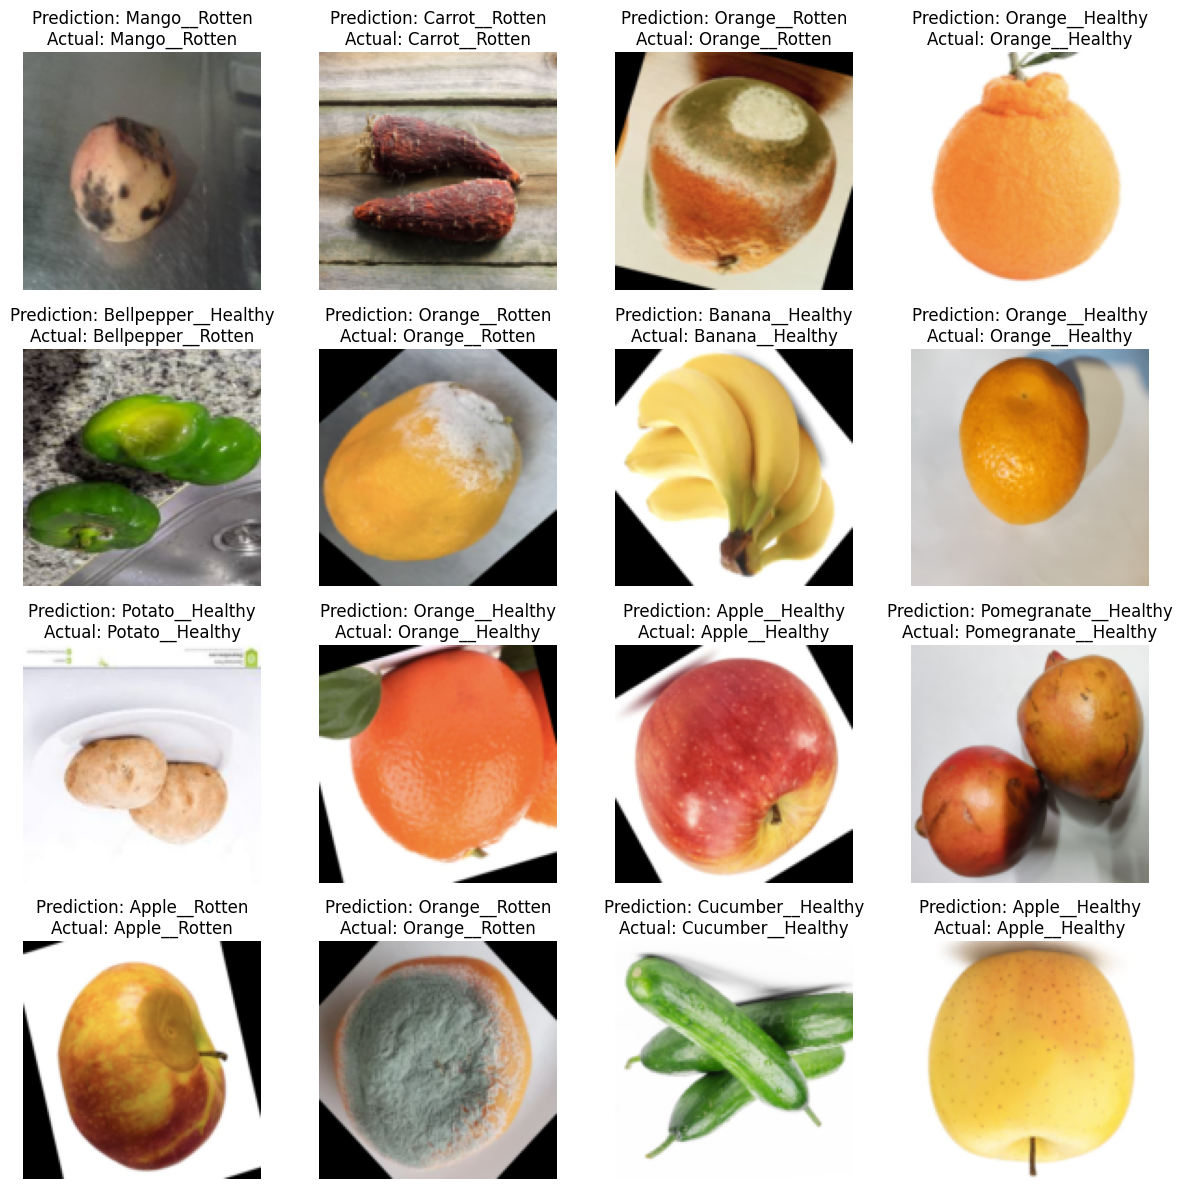

In [12]:
def show_images(images, titles, rows=4, cols=4):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 16
indices = random.sample(range(len(test_dataset)), num_images)
images, titles = [], []

model.eval()
with torch.no_grad():
    for idx in indices:
        image, label = test_dataset[idx]
        images.append(image)
        
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
        
        actual_class = data.classes[label]
        predicted_class = data.classes[predicted.item()]
        
        titles.append(f'Prediction: {predicted_class}\nActual: {actual_class}')

show_images(images, titles)